
Random Forest Model Performance Metrics (Cutoff=0.7):
--------------------------------------------------
AUC: 0.7842
Balanced Accuracy: 0.6933
Sensitivity: 0.7073
Specificity: 0.6792
Confusion Matrix:
[[36 17]
 [12 29]]


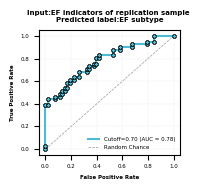

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, balanced_accuracy_score, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_data(file_path):
    """加载并预处理数据"""
    # 读取 followup 数据
    followup_df = pd.read_excel(file_path, sheet_name='Followup')
    followup_df = followup_df[followup_df['Label-0.65'] != 3]
    
    # 定义特征
    features = ['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc',
                'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']
    X_followup = followup_df[features]
    y_followup = followup_df['Label-0.65']
    return X_followup, y_followup

def load_models(model_path):
    """加载训练好的模型"""
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return {'RF': model}

def calculate_metrics(y_true, y_pred_prob):
    """计算各项评估指标"""
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # 计算 AUC
    auc_value = roc_auc_score(y_true, y_pred_prob)
    
    # 计算 BAC
    bac = balanced_accuracy_score(y_true, y_pred)
    
    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    
    # 计算 sensitivity 和 specificity
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # TPR
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # TNR
    
    return {
        'AUC': auc_value,
        'BAC': bac,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Confusion Matrix': cm
    }

def plot_rf_roc_curves(model_dicts, X_followups, y_followups, cutoffs):
    """绘制 cutoff=0.70 下 RF 模型的 ROC 曲线并输出评估指标"""
    plt.figure(figsize=(2, 2))
    
    # Nature 配色方案
    colors = ['#4DBBD5', '#E64B35', '#00A087', '#3C5488', '#F39B7F', '#8491B4']
    linestyles = ['-']  # 固定使用实线
    markers = ['P']      # 固定使用一种 marker
    
    for i, cutoff in enumerate(cutoffs):
        model_dict = model_dicts[i]
        X_followup = X_followups[i]
        y_followup = y_followups[i]
        
        print(f"\nRandom Forest Model Performance Metrics (Cutoff={cutoff}):")
        print("-" * 50)
        
        # 使用保存的 scaler 转换数据
        X_scaled = pd.DataFrame(
            model_dict['RF']['scaler'].transform(X_followup),
            columns=X_followup.columns,
            index=X_followup.index
        )
        
        # 获取预测概率
        y_pred_prob = model_dict['RF']['clf'].predict_proba(X_scaled)[:, 1]
        
        # 计算评估指标
        metrics = calculate_metrics(y_followup, y_pred_prob)
        
        # 打印评估指标
        print(f"AUC: {metrics['AUC']:.4f}")
        print(f"Balanced Accuracy: {metrics['BAC']:.4f}")
        print(f"Sensitivity: {metrics['Sensitivity']:.4f}")
        print(f"Specificity: {metrics['Specificity']:.4f}")
        print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}")
        
        # 计算 ROC 曲线
        fpr, tpr, thresholds = roc_curve(y_followup, y_pred_prob)

        # 绘制 ROC 曲线
        plt.plot(fpr, tpr, color=colors[i % len(colors)], linestyle=linestyles[0], lw=1.5, alpha=1, 
                 label=f'Cutoff={cutoff:.2f} (AUC = {metrics["AUC"]:.2f})')
        
        # 在每个点添加 marker
        for fp, tp in zip(fpr, tpr):
            plt.scatter(fp, tp, color=colors[i % len(colors)], marker=markers[0], s=5, zorder=10, 
                        alpha=1, edgecolors='black', linewidths=0.5)

    # 绘制随机分类器基准线
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', alpha=0.8, lw=0.5,
             label='Random Chance')
    
    # 设置图形属性  
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.tick_params(axis='both', which='major', labelsize=4)
    plt.xlabel('False Positive Rate', fontsize=4, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=4, fontweight='bold')
    plt.title('Input:EF indicators of replication sample \nPredicted label:EF subtype', fontsize=5, fontweight='bold', pad=6)
    
    # 添加网格
    plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.3)
    
    # 设置图例
    plt.legend(loc='lower right', frameon=False, fancybox=False,
               framealpha=0.8, fontsize=4)
    
    plt.tight_layout()
    plt.savefig('对比_ROC_Nature_with_markers_removed.jpg', dpi=2200, bbox_inches='tight')
    plt.show()

def main():
    # 仅保留 cutoff=0.70 的数据和模型路径
    cutoffs = [0.70]
    # 数据文件路径（根据实际情况修改，如下示例路径仅供参考）
    data_paths = [
        '/Users/zhangtongyi/Desktop/P0022024-认知聚类-project(最新版）/A.最新版本/3.控制total PANSS Scores/3.聚类后分析-控制PANSStotal/Classification analyses of EF subtypes /cutoff=0.70/rawdata.xlsx'
    ]
    # 模型文件路径更新为您提供的新路径
    model_paths = [
        '/Users/zhangtongyi/Desktop/P0022024-认知聚类-project(最新版）/A.最新版本/3.控制total PANSS Scores/3.聚类后分析-控制PANSStotal/Classification analyses of EF subtypes /cutoff=0.70/model_history_followup/RF_best.pkl'
    ]

    # 加载数据和模型
    X_followups = []
    y_followups = []
    model_dicts = []
    
    for data_path, model_path in zip(data_paths, model_paths):
        X_followup, y_followup = load_data(data_path)
        model_dict = load_models(model_path)
        
        X_followups.append(X_followup) 
        y_followups.append(y_followup)
        model_dicts.append(model_dict)
    
    # 绘制 ROC 曲线并输出评估指标
    plot_rf_roc_curves(model_dicts, X_followups, y_followups, cutoffs)

if __name__ == "__main__":
    main()